In [24]:
import pandas as pd
import numpy as np
import time
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
import pickle

print("="*60)
print("СОЗДАНИЕ ЭМБЕДДИНГОВ ДЛЯ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ")
print("="*60)

# === 1. ЗАГРУЗКА ДАННЫХ ===
print("\n[1/5] Загрузка данных...")
start_time = time.time()

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

# Очистка данных
movies.drop(['genres'], axis=1, inplace=True)
ratings.drop(['timestamp'], axis=1, inplace=True)

print(f"  ✓ Загружено {len(movies)} фильмов")
print(f"  ✓ Загружено {len(ratings)} оценок")
print(f"  ✓ Время: {time.time() - start_time:.2f}s")

# === 2. ПОДГОТОВКА МАТРИЦ (БЕЗ ПЛОТНЫХ МАТРИЦ!) ===
print("\n[2/5] Подготовка разреженных матриц...")
start_time = time.time()

# Фильтрация активных пользователей и популярных фильмов
user_votes = ratings.groupby('userId')['rating'].count()
movie_votes = ratings.groupby('movieId')['rating'].count()
active_users = user_votes[user_votes > 50].index
popular_movies = movie_votes[movie_votes > 10].index

print(f"  ✓ Активных пользователей: {len(active_users)}")
print(f"  ✓ Популярных фильмов: {len(popular_movies)}")

# Фильтруем ratings
ratings_filtered = ratings[
    ratings['userId'].isin(active_users) & 
    ratings['movieId'].isin(popular_movies)
].copy()

print(f"  ✓ Оценок после фильтрации: {len(ratings_filtered):,}")

# Создаём маппинг (убираем "пробелы" в матрице 1,3,7... -> 1,2,3...)
user_ids = sorted(ratings_filtered['userId'].unique())
movie_ids = sorted(ratings_filtered['movieId'].unique())

user_id_to_idx = {uid: idx for idx, uid in enumerate(user_ids)}
movie_id_to_idx = {mid: idx for idx, mid in enumerate(movie_ids)}

ratings_filtered['user_idx'] = ratings_filtered['userId'].map(user_id_to_idx)
ratings_filtered['movie_idx'] = ratings_filtered['movieId'].map(movie_id_to_idx)

# Создаём разреженную матрицу НАПРЯМУЮ из данных
n_users = len(user_ids)
n_movies = len(movie_ids)

sparse_matrix = csr_matrix(
    (ratings_filtered['rating'].values,
     (ratings_filtered['user_idx'].values, ratings_filtered['movie_idx'].values)),
    shape=(n_users, n_movies)
)

density = sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1])
print(f"  ✓ Размер матрицы: {n_users} пользователей × {n_movies} фильмов")
print(f"  ✓ Заполненность матрицы: {density*100:.2f}%")
print(f"  ✓ Известных оценок: {sparse_matrix.nnz:,}")
print(f"  ✓ Время: {time.time() - start_time:.2f}s")

# === 3. СОЗДАНИЕ ЭМБЕДДИНГОВ ===
print("\n[3/5] Создание эмбеддингов через Matrix Factorization (SVD)...")
print("  Это может занять несколько минут...")

embedding_dim = 128
n_epochs = 20  # можно увеличить для лучшего качества

start_time = time.time()

# Используем TruncatedSVD для разреженных матриц
svd = TruncatedSVD(
    n_components=embedding_dim,
    n_iter=n_epochs,
    random_state=42
)

# Обучение на данных пользователь-фильм
print(f"  → Обучение SVD с {embedding_dim} компонентами...")
user_embeddings = svd.fit_transform(sparse_matrix)

# Получаем эмбеддинги фильмов из компонент SVD
movie_embeddings = svd.components_.T

print(f"  ✓ Эмбеддинги пользователей: {user_embeddings.shape}")
print(f"  ✓ Эмбеддинги фильмов: {movie_embeddings.shape}")
print(f"  ✓ Объяснённая дисперсия: {svd.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  ✓ Время обучения: {time.time() - start_time:.2f}s")

# === 4. СОЗДАНИЕ DATAFRAME С ЭМБЕДДИНГАМИ ===
print("\n[4/5] Создание DataFrame с эмбеддингами...")
start_time = time.time()

# DataFrame для пользователей
user_embedding_columns = [f'emb_{i}' for i in range(embedding_dim)]
user_embeddings_df = pd.DataFrame(
    user_embeddings,
    index=user_ids,  # используем сохранённый список ID
    columns=user_embedding_columns
)
user_embeddings_df.index.name = 'userId'

# DataFrame для фильмов
movie_embeddings_df = pd.DataFrame(
    movie_embeddings,
    index=movie_ids,  # используем сохранённый список ID
    columns=user_embedding_columns
)
movie_embeddings_df.index.name = 'movieId'

# Добавляем названия фильмов для удобства
movie_info = movies.set_index('movieId')['title']
movie_embeddings_df = movie_embeddings_df.join(movie_info, how='left')

print(f"  ✓ User embeddings DataFrame: {user_embeddings_df.shape}")
print(f"  ✓ Movie embeddings DataFrame: {movie_embeddings_df.shape}")
print(f"  ✓ Время: {time.time() - start_time:.2f}s")

# === 5. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ===
print("\n[5/5] Сохранение эмбеддингов...")
start_time = time.time()

# Сохраняем в CSV
user_embeddings_df.to_csv('../data/processed/user_embeddings_128d.csv')
movie_embeddings_df.to_csv('../data/processed/movie_embeddings_128d.csv')

# Также сохраняем в NumPy формате (быстрее загружается)
np.save('../data/processed/user_embeddings_128d.npy', user_embeddings)
np.save('../data/processed/movie_embeddings_128d.npy', movie_embeddings)

# Сохраняем маппинг ID -> индекс для быстрого доступа
with open('../data/processed/user_id_mapping.pkl', 'wb') as f:
    pickle.dump(user_id_to_idx, f)

with open('../data/processed/movie_id_mapping.pkl', 'wb') as f:
    pickle.dump(movie_id_to_idx, f)

# Сохраняем модель SVD для возможности дообучения
with open('../data/processed/svd_model.pkl', 'wb') as f:
    pickle.dump(svd, f)

print(f"  ✓ user_embeddings_128d.csv ({user_embeddings_df.shape})")
print(f"  ✓ movie_embeddings_128d.csv ({movie_embeddings_df.shape})")
print(f"  ✓ user_embeddings_128d.npy")
print(f"  ✓ movie_embeddings_128d.npy")
print(f"  ✓ user_id_mapping.pkl")
print(f"  ✓ movie_id_mapping.pkl")
print(f"  ✓ svd_model.pkl")
print(f"  ✓ Время: {time.time() - start_time:.2f}s")

# Статистика по размерам
print("\n" + "="*60)
print("СТАТИСТИКА")
print("="*60)

import os

def get_file_size(filename):
    if os.path.exists(filename):
        size_mb = os.path.getsize(filename) / (1024 * 1024)
        return size_mb
    return 0

print("\nРазмеры файлов:")
print(f"  user_embeddings_128d.csv: {get_file_size('user_embeddings_128d.csv'):.2f} MB")
print(f"  movie_embeddings_128d.csv: {get_file_size('movie_embeddings_128d.csv'):.2f} MB")
print(f"  user_embeddings_128d.npy: {get_file_size('user_embeddings_128d.npy'):.2f} MB")
print(f"  movie_embeddings_128d.npy: {get_file_size('movie_embeddings_128d.npy'):.2f} MB")

total_embeddings_size = (get_file_size('user_embeddings_128d.npy') + 
                         get_file_size('movie_embeddings_128d.npy'))

print(f"\nОбщий размер эмбеддингов (npy): {total_embeddings_size:.2f} MB")

# Сравнение с исходной матрицей
original_size = sparse_matrix.shape[0] * sparse_matrix.shape[1] * 4 / (1024 * 1024)
compression_ratio = original_size / total_embeddings_size

print(f"Размер исходной матрицы (если бы была плотной): {original_size:.2f} MB")
print(f"Коэффициент сжатия: {compression_ratio:.1f}x")

print("\n" + "="*60)
print("✓ ВСЁ ГОТОВО!")
print("="*60)

СОЗДАНИЕ ЭМБЕДДИНГОВ ДЛЯ РЕКОМЕНДАТЕЛЬНОЙ СИСТЕМЫ

[1/5] Загрузка данных...
  ✓ Загружено 87585 фильмов
  ✓ Загружено 32000204 оценок
  ✓ Время: 8.68s

[2/5] Подготовка разреженных матриц...
  ✓ Активных пользователей: 126588
  ✓ Популярных фильмов: 30521
  ✓ Оценок после фильтрации: 29,446,791
  ✓ Размер матрицы: 126588 пользователей × 30521 фильмов
  ✓ Заполненность матрицы: 0.76%
  ✓ Известных оценок: 29,446,791
  ✓ Время: 2.66s

[3/5] Создание эмбеддингов через Matrix Factorization (SVD)...
  Это может занять несколько минут...
  → Обучение SVD с 128 компонентами...
  ✓ Эмбеддинги пользователей: (126588, 128)
  ✓ Эмбеддинги фильмов: (30521, 128)
  ✓ Объяснённая дисперсия: 42.07%
  ✓ Время обучения: 84.99s

[4/5] Создание DataFrame с эмбеддингами...
  ✓ User embeddings DataFrame: (126588, 128)
  ✓ Movie embeddings DataFrame: (30521, 129)
  ✓ Время: 0.08s

[5/5] Сохранение эмбеддингов...
  ✓ user_embeddings_128d.csv ((126588, 128))
  ✓ movie_embeddings_128d.csv ((30521, 129))
  ✓ use

ЗАГРУЗКА ЭМБЕДДИНГОВ ДЛЯ KNN-БЕНЧМАРКА
✓ Загружено эмбеддингов пользователей: (126588, 128)
✓ Загружено эмбеддингов фильмов: (30521, 128)
✓ Размерность эмбеддингов: 128

=== Построение индексов на эмбеддингах ===

Построение Exact KNN...
  User-based: 0.006s, 0.00 MB
  Item-based: 0.002s, 0.00 MB

Построение Annoy...
  User-based: 1.175s, 83.25 MB
  Item-based: 0.245s, 0.25 MB

Построение FAISS...
  User-based: 0.259s, 61.90 MB
  Item-based: 0.144s, 0.00 MB

Построение HNSW...
  User-based: 6.447s, 78.07 MB
  Item-based: 0.378s, 0.00 MB

=== Тестирование производительности ===

Тестирование Exact KNN...

Тестирование Annoy...

Тестирование FAISS...

Тестирование HNSW...

=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===
Algorithm  Build Time User (s)  Build Time Item (s)  Memory User (MB)  Memory Item (MB)  Avg Query Time User (ms)  Avg Query Time Item (ms)  Recall@20 User  Recall@20 Item  Precision@20 User  Precision@20 Item
Exact KNN             0.006063             0.001553          0.000000             

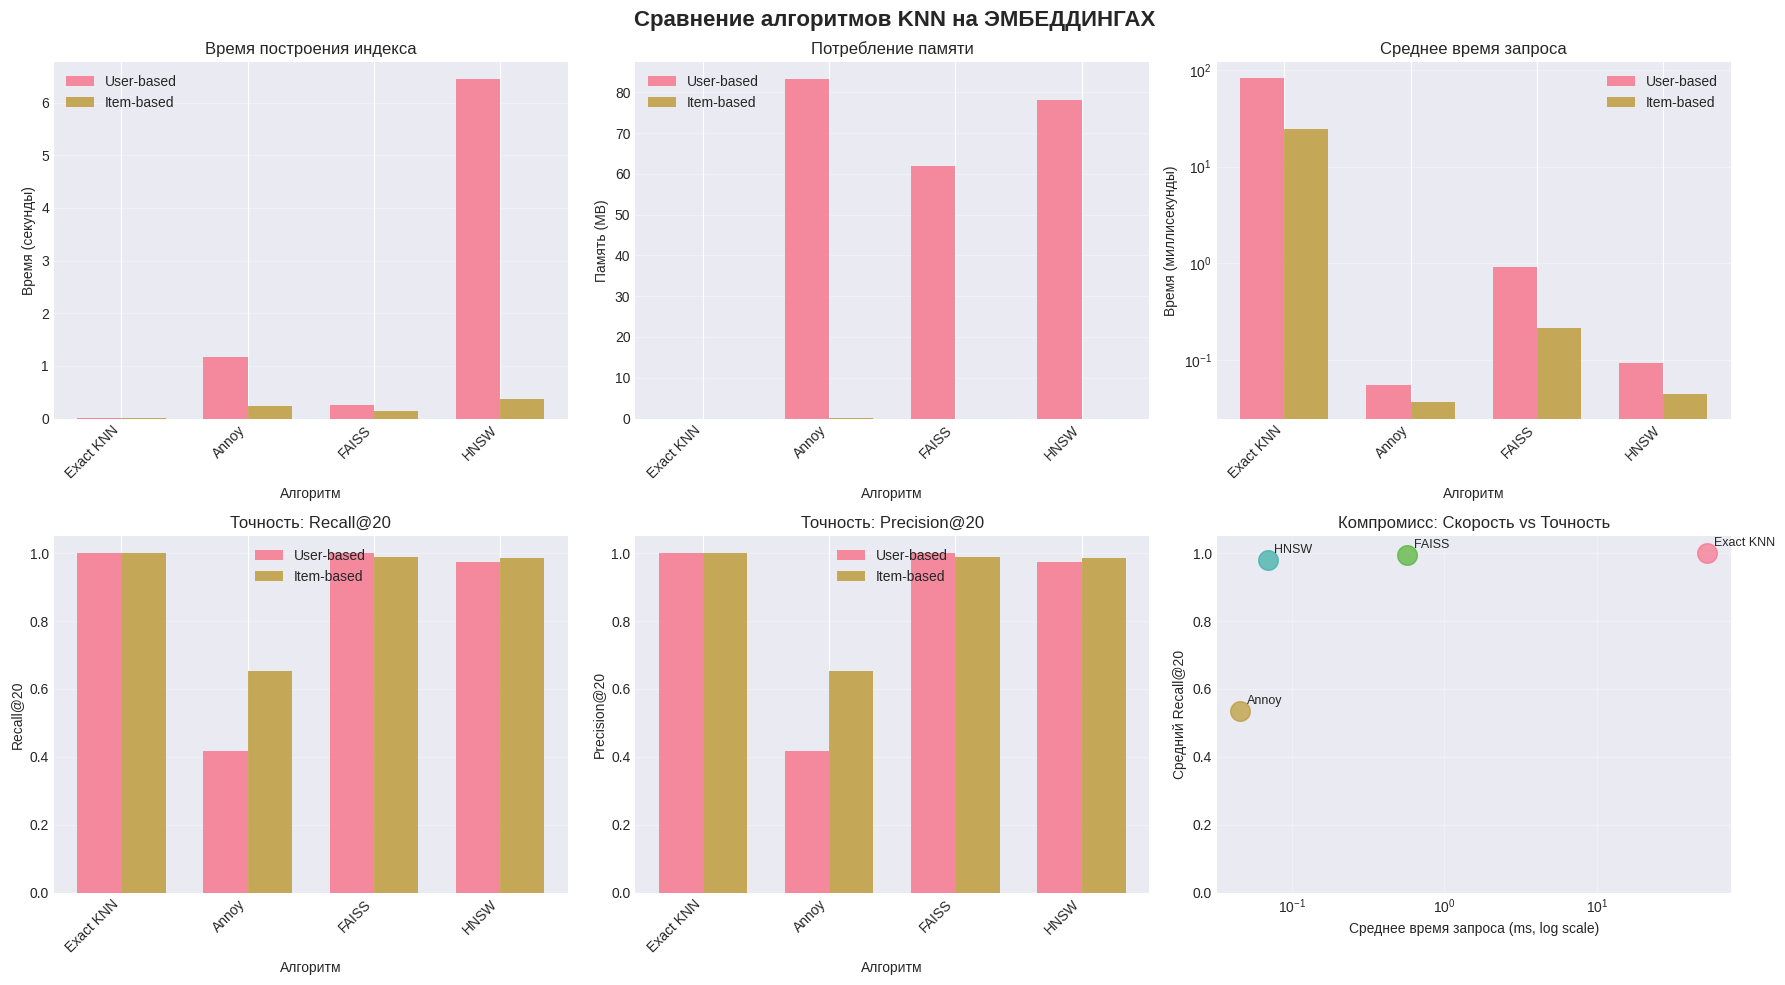


=== ДЕТАЛЬНЫЙ АНАЛИЗ ===

1. СКОРОСТЬ:
------------------------------------------------------------
Самое быстрое построение (User): Exact KNN (0.006s)
Самое быстрое построение (Item): Exact KNN (0.002s)
Самый быстрый запрос (User): Annoy (0.0548ms)
Самый быстрый запрос (Item): Annoy (0.0365ms)

2. ПАМЯТЬ:
------------------------------------------------------------
Наименьшее потребление (User): Exact KNN (0.00 MB)
Наименьшее потребление (Item): Exact KNN (0.00 MB)

3. ТОЧНОСТЬ:
------------------------------------------------------------
Лучший Recall (User): Exact KNN (1.0000)
Лучший Recall (Item): Exact KNN (1.0000)
Лучший Precision (User): Exact KNN (1.0000)
Лучший Precision (Item): Exact KNN (1.0000)

Анализ завершён!


In [25]:
import pandas as pd
import numpy as np
import time
import psutil
import os
import pickle
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns

# Установка библиотек (раскомментируйте при необходимости):
# pip install annoy faiss-cpu hnswlib

from annoy import AnnoyIndex
import faiss
import hnswlib

# === ЗАГРУЗКА ЭМБЕДДИНГОВ ВМЕСТО ИСХОДНЫХ ДАННЫХ ===
print("="*60)
print("ЗАГРУЗКА ЭМБЕДДИНГОВ ДЛЯ KNN-БЕНЧМАРКА")
print("="*60)

try:
    user_embeddings = np.load('../data/processed/user_embeddings_128d.npy')
    movie_embeddings = np.load('../data/processed/movie_embeddings_128d.npy')

    with open('../data/processed/user_id_mapping.pkl', 'rb') as f:
        user_id_to_idx = pickle.load(f)
    with open('../data/processed/movie_id_mapping.pkl', 'rb') as f:
        movie_id_to_idx = pickle.load(f)

    # Создаем обратные маппинги для удобства (индекс -> ID)
    idx_to_user_id = {v: k for k, v in user_id_to_idx.items()}
    idx_to_movie_id = {v: k for k, v in movie_id_to_idx.items()}

    print(f"✓ Загружено эмбеддингов пользователей: {user_embeddings.shape}")
    print(f"✓ Загружено эмбеддингов фильмов: {movie_embeddings.shape}")
    print(f"✓ Размерность эмбеддингов: {user_embeddings.shape[1]}")

except FileNotFoundError as e:
    print(f"ОШИБКА: Файл не найден: {e}")
    print("Пожалуйста, сначала запустите первый скрипт для создания эмбеддингов.")
    exit()


# === Класс для измерения памяти ===
class MemoryTracker:
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.start_mem = 0
    
    def start(self):
        self.start_mem = self.process.memory_info().rss / 1024 / 1024  # MB
    
    def get_usage(self):
        current = self.process.memory_info().rss / 1024 / 1024
        return current - self.start_mem

# === 1. Точный KNN (sklearn) ===
class ExactKNN:
    def __init__(self, n_neighbors=20):
        self.n_neighbors = n_neighbors
        self.model_user = None
        self.model_item = None
        self.build_time_user = 0
        self.build_time_item = 0
        self.memory_user = 0
        self.memory_item = 0
        
    def build(self, user_embeddings, movie_embeddings):
        mem = MemoryTracker()
        
        # User-based
        mem.start()
        start = time.time()
        self.model_user = NearestNeighbors(metric='cosine', algorithm='brute', 
                                          n_neighbors=self.n_neighbors, n_jobs=-1)
        self.model_user.fit(user_embeddings)
        self.build_time_user = time.time() - start
        self.memory_user = mem.get_usage()
        
        # Item-based
        mem.start()
        start = time.time()
        self.model_item = NearestNeighbors(metric='cosine', algorithm='brute',
                                          n_neighbors=self.n_neighbors, n_jobs=-1)
        self.model_item.fit(movie_embeddings)
        self.build_time_item = time.time() - start
        self.memory_item = mem.get_usage()
        
    def query_user(self, vector, k=20):
        start = time.time()
        # reshape(1, -1) — преобразуем вектор в матрицу 1×D, потому что kneighbors требует 2D-вход (n_samples × n_features)
        # (128,) -> (1, 128)
        distances, indices = self.model_user.kneighbors(vector.reshape(1, -1), n_neighbors=k)
        query_time = time.time() - start
        return distances.flatten(), indices.flatten(), query_time
    
    def query_item(self, vector, k=20):
        start = time.time()
        distances, indices = self.model_item.kneighbors(vector.reshape(1, -1), n_neighbors=k)
        query_time = time.time() - start
        return distances.flatten(), indices.flatten(), query_time

# === 2. Annoy ===
class AnnoyKNN:
    def __init__(self, n_neighbors=20, n_trees=50):
        self.n_neighbors = n_neighbors
        self.n_trees = n_trees
        self.index_user = None
        self.index_item = None
        self.build_time_user = 0
        self.build_time_item = 0
        self.memory_user = 0
        self.memory_item = 0
        
    def build(self, user_embeddings, movie_embeddings):
        mem = MemoryTracker()
        
        # User-based
        mem.start()
        start = time.time()
        n_users, n_features = user_embeddings.shape
        self.index_user = AnnoyIndex(n_features, 'angular')
        for i in range(n_users):
            self.index_user.add_item(i, user_embeddings[i])
        self.index_user.build(self.n_trees)
        self.build_time_user = time.time() - start
        self.memory_user = mem.get_usage()
        
        # Item-based
        mem.start()
        start = time.time()
        n_items, n_features = movie_embeddings.shape
        self.index_item = AnnoyIndex(n_features, 'angular')
        for i in range(n_items):
            self.index_item.add_item(i, movie_embeddings[i])
        self.index_item.build(self.n_trees)
        self.build_time_item = time.time() - start
        self.memory_item = mem.get_usage()
        
    def query_user(self, vector, k=20):
        start = time.time()
        indices, distances = self.index_user.get_nns_by_vector(vector, k, include_distances=True)
        query_time = time.time() - start
        return np.array(distances), np.array(indices), query_time
    
    def query_item(self, vector, k=20):
        start = time.time()
        indices, distances = self.index_item.get_nns_by_vector(vector, k, include_distances=True)
        query_time = time.time() - start
        return np.array(distances), np.array(indices), query_time

# === 3. FAISS ===
class FAISSKNN:
    def __init__(self, n_neighbors=20, nlist=500):
        self.n_neighbors = n_neighbors
        self.nlist = nlist
        self.index_user = None
        self.index_item = None
        self.build_time_user = 0
        self.build_time_item = 0
        self.memory_user = 0
        self.memory_item = 0
        
    def build(self, user_embeddings, movie_embeddings):
        mem = MemoryTracker()
        
        # User-based
        mem.start()
        start = time.time()
    
        data_user = user_embeddings.astype('float32')
        faiss.normalize_L2(data_user)
        n_users, dim = data_user.shape
        
        quantizer = faiss.IndexFlatIP(dim)
        self.index_user = faiss.IndexIVFFlat(quantizer, dim, min(self.nlist, n_users // 10))
        self.index_user.train(data_user)
        self.index_user.add(data_user)
        self.index_user.nprobe = 20
        
        self.build_time_user = time.time() - start
        self.memory_user = mem.get_usage()
        
        # Item-based
        mem.start()
        start = time.time()
        data_item = movie_embeddings.astype('float32')
        faiss.normalize_L2(data_item)
        n_items, dim = data_item.shape
        
        quantizer = faiss.IndexFlatIP(dim)
        self.index_item = faiss.IndexIVFFlat(quantizer, dim, min(self.nlist, n_items // 10))
        self.index_item.train(data_item)
        self.index_item.add(data_item)
        self.index_item.nprobe = 20
        
        self.build_time_item = time.time() - start
        self.memory_item = mem.get_usage()
        
    def query_user(self, vector, k=20):
        start = time.time()
        vec = vector.astype('float32').reshape(1, -1)
        faiss.normalize_L2(vec)
        distances, indices = self.index_user.search(vec, k)
        query_time = time.time() - start
        distances = 1 - distances.flatten()
        return distances, indices.flatten(), query_time
    
    def query_item(self, vector, k=20):
        start = time.time()
        vec = vector.astype('float32').reshape(1, -1)
        faiss.normalize_L2(vec)
        distances, indices = self.index_item.search(vec, k)
        query_time = time.time() - start
        distances = 1 - distances.flatten()
        return distances, indices.flatten(), query_time

# === 4. HNSW ===
class HNSWKNN:
    def __init__(self, n_neighbors=20, ef_construction=400, M=32):
        self.n_neighbors = n_neighbors
        self.ef_construction = ef_construction
        self.M = M
        self.index_user = None
        self.index_item = None
        self.build_time_user = 0
        self.build_time_item = 0
        self.memory_user = 0
        self.memory_item = 0
        
    def build(self, user_embeddings, movie_embeddings):
        mem = MemoryTracker()
        
        # User-based
        mem.start()
        start = time.time()
        n_users, dim = user_embeddings.shape
        self.index_user = hnswlib.Index(space='cosine', dim=dim)
        self.index_user.init_index(max_elements=n_users, ef_construction=self.ef_construction, M=self.M)
        self.index_user.add_items(user_embeddings, np.arange(n_users))
        self.index_user.set_ef(50)
        self.build_time_user = time.time() - start
        self.memory_user = mem.get_usage()
        
        # Item-based
        mem.start()
        start = time.time()
        n_items, dim = movie_embeddings.shape # ### ИЗМЕНЕНИЕ ###
        self.index_item = hnswlib.Index(space='cosine', dim=dim)
        self.index_item.init_index(max_elements=n_items, ef_construction=self.ef_construction, M=self.M)
        self.index_item.add_items(movie_embeddings, np.arange(n_items)) # ### ИЗМЕНЕНИЕ ###
        self.index_item.set_ef(50)
        self.build_time_item = time.time() - start
        self.memory_item = mem.get_usage()
        
    def query_user(self, vector, k=20):
        start = time.time()
        indices, distances = self.index_user.knn_query(vector, k=k)
        query_time = time.time() - start
        return distances.flatten(), indices.flatten(), query_time
    
    def query_item(self, vector, k=20):
        start = time.time()
        indices, distances = self.index_item.knn_query(vector, k=k)
        query_time = time.time() - start
        return distances.flatten(), indices.flatten(), query_time

# === Построение всех индексов ===
print("\n=== Построение индексов на эмбеддингах ===")
models = {
    'Exact KNN': ExactKNN(n_neighbors=20),
    'Annoy': AnnoyKNN(n_neighbors=20, n_trees=10),
    'FAISS': FAISSKNN(n_neighbors=20, nlist=100),
    'HNSW': HNSWKNN(n_neighbors=20, ef_construction=200, M=16)
}

for name, model in models.items():
    print(f"\nПостроение {name}...")
    model.build(user_embeddings, movie_embeddings)
    print(f"  User-based: {model.build_time_user:.3f}s, {model.memory_user:.2f} MB")
    print(f"  Item-based: {model.build_time_item:.3f}s, {model.memory_item:.2f} MB")

# === Тестирование на случайных запросах ===
print("\n=== Тестирование производительности ===")
n_test_queries = 100
test_user_indices = np.random.choice(user_embeddings.shape[0], n_test_queries, replace=False)
test_item_indices = np.random.choice(movie_embeddings.shape[0], n_test_queries, replace=False)

# Получаем эталонные результаты от Exact KNN
exact_model = models['Exact KNN']
exact_results_user = []
exact_results_item = []

for idx in test_user_indices:
    _, indices, _ = exact_model.query_user(user_embeddings[idx], k=20)
    exact_results_user.append(set(indices))

for idx in test_item_indices:
    _, indices, _ = exact_model.query_item(movie_embeddings[idx], k=20)
    exact_results_item.append(set(indices))

# Сравнение всех моделей
results = []

for name, model in models.items():
    print(f"\nТестирование {name}...")
    
    # User-based метрики
    query_times_user = []
    recalls_user = []
    precisions_user = []
    
    for i, idx in enumerate(test_user_indices):
        _, indices, query_time = model.query_user(user_embeddings[idx], k=20)
        query_times_user.append(query_time)
        
        predicted = set(indices)
        true = exact_results_user[i]
        
        intersection = len(predicted & true)
        recall = intersection / len(true) if len(true) > 0 else 0
        precision = intersection / len(predicted) if len(predicted) > 0 else 0
        
        recalls_user.append(recall)
        precisions_user.append(precision)
    
    # Item-based метрики
    query_times_item = []
    recalls_item = []
    precisions_item = []
    
    for i, idx in enumerate(test_item_indices):
        _, indices, query_time = model.query_item(movie_embeddings[idx], k=20)
        query_times_item.append(query_time)
        
        predicted = set(indices)
        true = exact_results_item[i]
        
        intersection = len(predicted & true)
        recall = intersection / len(true) if len(true) > 0 else 0
        precision = intersection / len(predicted) if len(predicted) > 0 else 0
        
        recalls_item.append(recall)
        precisions_item.append(precision)
    
    results.append({
        'Algorithm': name,
        'Build Time User (s)': model.build_time_user,
        'Build Time Item (s)': model.build_time_item,
        'Memory User (MB)': model.memory_user,
        'Memory Item (MB)': model.memory_item,
        'Avg Query Time User (ms)': np.mean(query_times_user) * 1000,
        'Avg Query Time Item (ms)': np.mean(query_times_item) * 1000,
        'Recall@20 User': np.mean(recalls_user),
        'Recall@20 Item': np.mean(recalls_item),
        'Precision@20 User': np.mean(precisions_user),
        'Precision@20 Item': np.mean(precisions_item)
    })

# === Таблица результатов ===
df_results = pd.DataFrame(results)
print("\n=== ИТОГОВЫЕ РЕЗУЛЬТАТЫ ===")
print(df_results.to_string(index=False))

# Сохранение
df_results.to_csv('knn_comparison_on_embeddings_results.csv', index=False)
print("\nРезультаты сохранены в 'knn_comparison_on_embeddings_results.csv'")

# === Визуализация ===
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Сравнение алгоритмов KNN на ЭМБЕДДИНГАХ', fontsize=16, fontweight='bold') # ### ИЗМЕНЕНИЕ ###

# 1. Время построения индекса
ax = axes[0, 0]
x = np.arange(len(df_results))
width = 0.35
ax.bar(x - width/2, df_results['Build Time User (s)'], width, label='User-based', alpha=0.8)
ax.bar(x + width/2, df_results['Build Time Item (s)'], width, label='Item-based', alpha=0.8)
ax.set_xlabel('Алгоритм')
ax.set_ylabel('Время (секунды)')
ax.set_title('Время построения индекса')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Algorithm'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 2. Потребление памяти
ax = axes[0, 1]
ax.bar(x - width/2, df_results['Memory User (MB)'], width, label='User-based', alpha=0.8)
ax.bar(x + width/2, df_results['Memory Item (MB)'], width, label='Item-based', alpha=0.8)
ax.set_xlabel('Алгоритм')
ax.set_ylabel('Память (MB)')
ax.set_title('Потребление памяти')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Algorithm'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 3. Время запроса
ax = axes[0, 2]
ax.bar(x - width/2, df_results['Avg Query Time User (ms)'], width, label='User-based', alpha=0.8)
ax.bar(x + width/2, df_results['Avg Query Time Item (ms)'], width, label='Item-based', alpha=0.8)
ax.set_xlabel('Алгоритм')
ax.set_ylabel('Время (миллисекунды)')
ax.set_title('Среднее время запроса')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Algorithm'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_yscale('log')

# 4. Recall@20
ax = axes[1, 0]
ax.bar(x - width/2, df_results['Recall@20 User'], width, label='User-based', alpha=0.8)
ax.bar(x + width/2, df_results['Recall@20 Item'], width, label='Item-based', alpha=0.8)
ax.set_xlabel('Алгоритм')
ax.set_ylabel('Recall@20')
ax.set_title('Точность: Recall@20')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Algorithm'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# 5. Precision@20
ax = axes[1, 1]
ax.bar(x - width/2, df_results['Precision@20 User'], width, label='User-based', alpha=0.8)
ax.bar(x + width/2, df_results['Precision@20 Item'], width, label='Item-based', alpha=0.8)
ax.set_xlabel('Алгоритм')
ax.set_ylabel('Precision@20')
ax.set_title('Точность: Precision@20')
ax.set_xticks(x)
ax.set_xticklabels(df_results['Algorithm'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])

# 6. Trade-off: Скорость vs Точность
ax = axes[1, 2]
for i, row in df_results.iterrows():
    avg_query_time = (row['Avg Query Time User (ms)'] + row['Avg Query Time Item (ms)']) / 2
    avg_recall = (row['Recall@20 User'] + row['Recall@20 Item']) / 2
    ax.scatter(avg_query_time, avg_recall, s=200, alpha=0.7, label=row['Algorithm'])
    ax.annotate(row['Algorithm'], (avg_query_time, avg_recall), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax.set_xlabel('Среднее время запроса (ms, log scale)')
ax.set_ylabel('Средний Recall@20')
ax.set_title('Компромисс: Скорость vs Точность')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('knn_comparison_on_embeddings.png', dpi=300, bbox_inches='tight') # ### ИЗМЕНЕНИЕ ###
print("\nГрафики сохранены в 'knn_comparison_on_embeddings.png'")
plt.show()

# === Детальный анализ (ИСПРАВЛЕННАЯ ВЕРСИЯ) ===
print("\n=== ДЕТАЛЬНЫЙ АНАЛИЗ ===")
print("\n1. СКОРОСТЬ:")
print("-" * 60)
fastest_build_user = df_results.loc[df_results['Build Time User (s)'].idxmin()]
fastest_build_item = df_results.loc[df_results['Build Time Item (s)'].idxmin()]
fastest_query_user = df_results.loc[df_results['Avg Query Time User (ms)'].idxmin()]
fastest_query_item = df_results.loc[df_results['Avg Query Time Item (ms)'].idxmin()]

print(f"Самое быстрое построение (User): {fastest_build_user['Algorithm']} ({fastest_build_user['Build Time User (s)']:.3f}s)")
print(f"Самое быстрое построение (Item): {fastest_build_item['Algorithm']} ({fastest_build_item['Build Time Item (s)']:.3f}s)")
print(f"Самый быстрый запрос (User): {fastest_query_user['Algorithm']} ({fastest_query_user['Avg Query Time User (ms)']:.4f}ms)")
print(f"Самый быстрый запрос (Item): {fastest_query_item['Algorithm']} ({fastest_query_item['Avg Query Time Item (ms)']:.4f}ms)")

print("\n2. ПАМЯТЬ:")
print("-" * 60)
min_mem_user = df_results.loc[df_results['Memory User (MB)'].idxmin()]
min_mem_item = df_results.loc[df_results['Memory Item (MB)'].idxmin()]
print(f"Наименьшее потребление (User): {min_mem_user['Algorithm']} ({min_mem_user['Memory User (MB)']:.2f} MB)")
print(f"Наименьшее потребление (Item): {min_mem_item['Algorithm']} ({min_mem_item['Memory Item (MB)']:.2f} MB)")

print("\n3. ТОЧНОСТЬ:")
print("-" * 60)
best_recall_user = df_results.loc[df_results['Recall@20 User'].idxmax()]
best_recall_item = df_results.loc[df_results['Recall@20 Item'].idxmax()]
print(f"Лучший Recall (User): {best_recall_user['Algorithm']} ({best_recall_user['Recall@20 User']:.4f})")
print(f"Лучший Recall (Item): {best_recall_item['Algorithm']} ({best_recall_item['Recall@20 Item']:.4f})")

# Для полноты картины исправим и Precision, хотя ошибка там еще не проявилась
best_precision_user = df_results.loc[df_results['Precision@20 User'].idxmax()]
best_precision_item = df_results.loc[df_results['Precision@20 Item'].idxmax()]
print(f"Лучший Precision (User): {best_precision_user['Algorithm']} ({best_precision_user['Precision@20 User']:.4f})")
print(f"Лучший Precision (Item): {best_precision_item['Algorithm']} ({best_precision_item['Precision@20 Item']:.4f})")
print("\n" + "="*60)
print("Анализ завершён!")